## load the dataset and create the final using dataset with attribute "Quadrant". 

In [7]:
import os
import pandas as pd
from pathlib import Path

ternary_folder_Q1 = Path("/Users/homeyellow/Desktop/cell-identification-ML/projectdata/images/uncentred_ternary_224_stratified4fold_1000per_seed3888/Q1")
ternary_folder_Q2 = Path("/Users/homeyellow/Desktop/cell-identification-ML/projectdata/images/uncentred_ternary_224_stratified4fold_1000per_seed3888/Q2")
ternary_folder_Q3 = Path("/Users/homeyellow/Desktop/cell-identification-ML/projectdata/images/uncentred_ternary_224_stratified4fold_1000per_seed3888/Q3")
ternary_folder_Q4 = Path("/Users/homeyellow/Desktop/cell-identification-ML/projectdata/images/uncentred_ternary_224_stratified4fold_1000per_seed3888/Q4")
# multiclass_folder = Path("projectdata/images/uncentred_multiclass_224_stratified4fold_1000per_seed3888")


In [8]:
# Prepare a list for all records
records = []
cell_types = ["Tumor", "Non-Tumor", "Empty"]
    
# Traverse folders
def get_records(quadrant, path):
    records = []
    
    for folder_name in os.listdir(path):
        folder_path = Path(f"{path}/{folder_name}")
        if folder_path.is_dir():
            
            if folder_name not in cell_types:
                print(f"Warning: Folder {folder_name} not found in cell types. Skipping.")
                continue
    
            # Loop through images
            for file_name in os.listdir(folder_path):
                if file_name.endswith((".png", ".jpg", ".jpeg")):
                    full_path = f"{folder_path}/{file_name}"
                    filename = "grid_99_87_224.png"
                    parts = filename.replace(".png", "").split("_")
                    x = int(parts[1])
                    y = int(parts[2])
    
                    # Try to extract index from filename (assume number in filename)
                    # Example filename: "img_123.png" → index=123
                    import re
                    match = re.search(r'\d+', file_name)
                    img_index = int(match.group()) if match else None
    
                    records.append({
                        "Quadrant": quadrant,
                        "File Name": file_name,
                        "Path": str(full_path),
                        "Category Type": folder_name,
                        "Image Index": img_index,
                        "x":x,
                        "y":y
                    })
    return records

records_q1 = get_records("Q1", ternary_folder_Q1)
records_q2 = get_records("Q2", ternary_folder_Q2)
records_q3 = get_records("Q3", ternary_folder_Q3)
records_q4 = get_records("Q4", ternary_folder_Q4)

df_q1 = pd.DataFrame(records_q1)
df_q2 = pd.DataFrame(records_q2)
df_q3 = pd.DataFrame(records_q3)
df_q4 = pd.DataFrame(records_q4)

# # Create DataFrame
# df_image_raw = pd.DataFrame(records)
# df_image_raw.head()

# df_image = df_image_raw[df_image_raw['Category Type'] != "Unlabeled"].reset_index(drop=True)


In [9]:
df_final = pd.concat([df_q1, df_q2, df_q3, df_q4])
# df_final
df_final.to_csv("used_dataset_bindy.csv", index=False)
df_g = df_final.groupby("Category Type")["File Name"].count()
df_g

Category Type
Empty         512
Non-Tumor    2000
Tumor        2000
Name: File Name, dtype: int64

In [10]:
df_g2 = df_final.groupby("Quadrant")["Category Type"].count()
df_g2

Quadrant
Q1    1128
Q2    1128
Q3    1128
Q4    1128
Name: Category Type, dtype: int64

## Implementing the VGG16 model

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set random seeds
np.random.seed(3888)
tf.random.set_seed(3888)

# # Load your balanced dataset
# df = df_final

# # Print basic info
# print(df['Category Type'].value_counts())
# print(df['Quadrant'].value_counts())

label_map = {'Tumor': 0, 'Non-Tumor': 1, 'Empty': 2}

df_q1['label'] = df_q1['Category Type'].map(label_map)
df_q1['label'] = df_q1['label'].astype(str)

df_q2['label'] = df_q2['Category Type'].map(label_map)
df_q2['label'] = df_q2['label'].astype(str)

df_q3['label'] = df_q3['Category Type'].map(label_map)
df_q3['label'] = df_q3['label'].astype(str)

df_q4['label'] = df_q4['Category Type'].map(label_map)
df_q4['label'] = df_q4['label'].astype(str)

def build_vgg16_model(input_shape=(224, 224, 3), path=None):
    base_model = VGG16(weights='imagenet' or path, include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(3, activation='softmax')(x)  # 3 classes

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


Starting Fold: Test on Q1
Found 1128 validated image filenames belonging to 3 classes.
Found 3384 validated image filenames belonging to 3 classes.


2025-05-23 19:26:56.955499: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-05-23 19:26:56.955531: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-05-23 19:26:56.955535: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-05-23 19:26:56.955603: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-23 19:26:56.955632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/homeyellow/anaconda3/envs/tfenv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super

Epoch 1/20


2025-05-23 19:26:58.669341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 499ms/step - accuracy: 0.4476 - loss: 1.0779 - val_accuracy: 0.6342 - val_loss: 0.8633
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 485ms/step - accuracy: 0.5223 - loss: 0.9632 - val_accuracy: 0.6546 - val_loss: 0.7702
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 481ms/step - accuracy: 0.5519 - loss: 0.8731 - val_accuracy: 0.6336 - val_loss: 0.7169
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 481ms/step - accuracy: 0.6015 - loss: 0.8111 - val_accuracy: 0.6631 - val_loss: 0.6618
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 487ms/step - accuracy: 0.6720 - loss: 0.7427 - val_accuracy: 0.6965 - val_loss: 0.6149
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 487ms/step - accuracy: 0.6502 - loss: 0.7216 - val_accuracy: 0.7408 - val_loss: 0.5970
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 474ms/step - accuracy: 0.6988 - loss: 0.6724 - val_accuracy: 0.7462 - val_loss: 0.5831
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 474ms/step - accuracy: 0.6795 - loss: 0.6777 - val_accuracy: 0.749

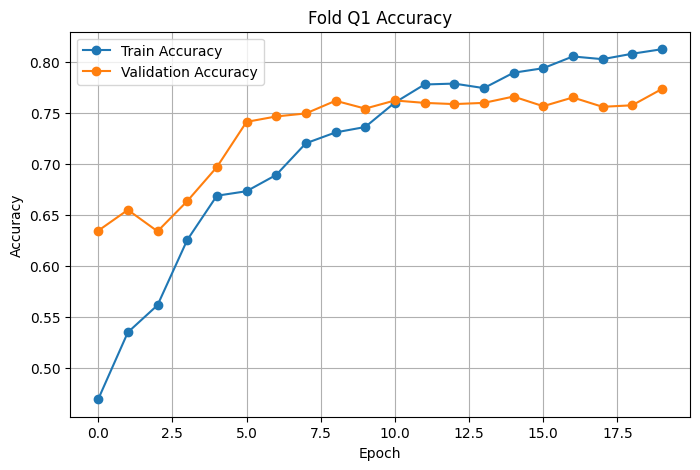

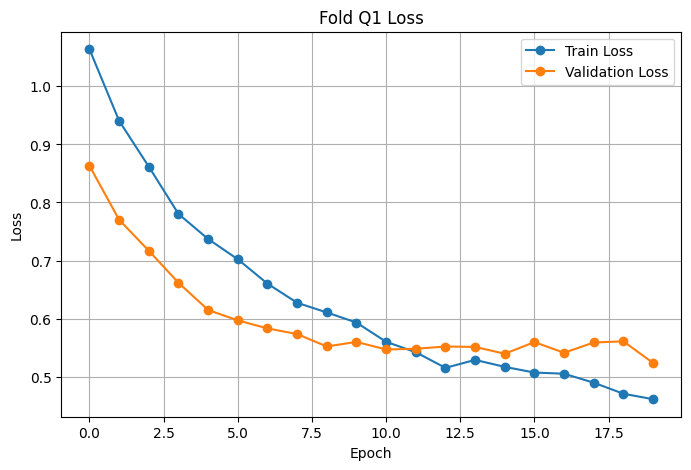

Saved model: vgg16_fold_Q1.h5
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step


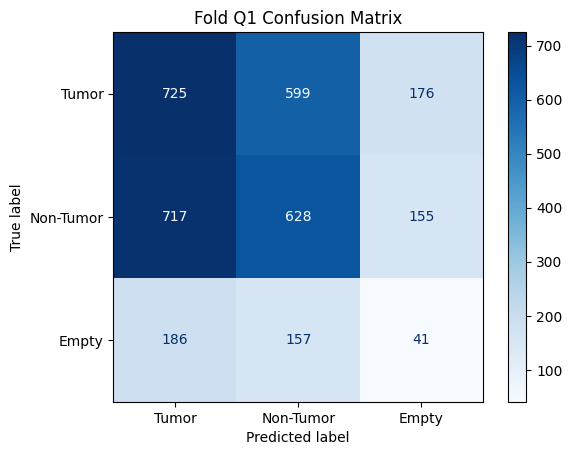

Fold Q1 Accuracy: 0.4119, F1 Score: 0.3358
Classification Report for Fold Q1:
              precision    recall  f1-score   support

       Tumor     0.4453    0.4833    0.4636      1500
   Non-Tumor     0.4538    0.4187    0.4355      1500
       Empty     0.1102    0.1068    0.1085       384

    accuracy                         0.4119      3384
   macro avg     0.3364    0.3363    0.3358      3384
weighted avg     0.4110    0.4119    0.4108      3384

Starting Fold: Test on Q2
Found 1128 validated image filenames belonging to 3 classes.
Found 3384 validated image filenames belonging to 3 classes.


/Users/homeyellow/anaconda3/envs/tfenv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 500ms/step - accuracy: 0.3734 - loss: 1.1952 - val_accuracy: 0.5872 - val_loss: 0.8922
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 490ms/step - accuracy: 0.4837 - loss: 0.9848 - val_accuracy: 0.6729 - val_loss: 0.7890
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 485ms/step - accuracy: 0.5506 - loss: 0.9015 - val_accuracy: 0.6741 - val_loss: 0.7198
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 491ms/step - accuracy: 0.5945 - loss: 0.8370 - val_accuracy: 0.6924 - val_loss: 0.6649
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 483ms/step - accuracy: 0.6188 - loss: 0.7967 - val_accuracy: 0.7057 - val_loss: 0.6278
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 477ms/step - accuracy: 0.6573 - loss: 0.7449 - val_accuracy: 0.7057 - val_loss: 0.6021
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 475ms/step - accuracy: 0.6879 - loss: 0.6698 - val_accuracy: 0.7524 - val_loss: 0.5826
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 476ms/step - accuracy: 0.7028 - loss: 0.6902 - val_accu

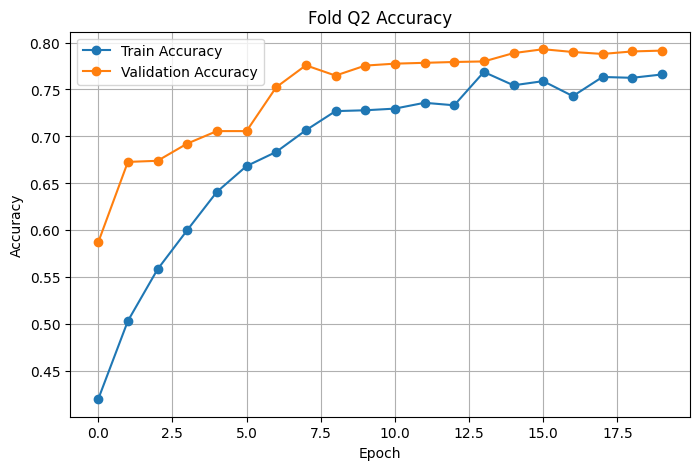

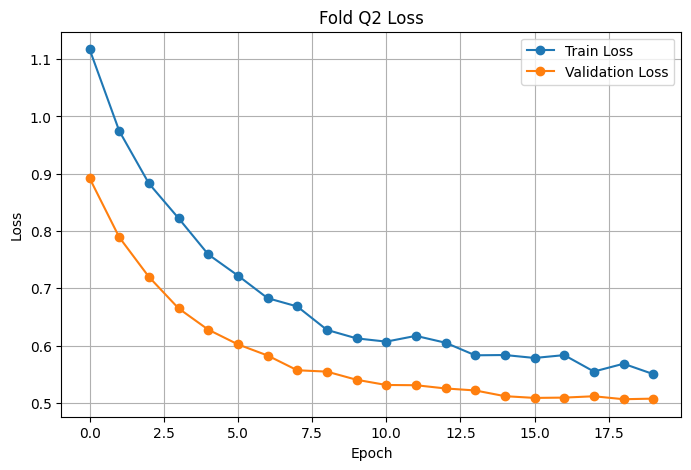

Saved model: vgg16_fold_Q2.h5
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step


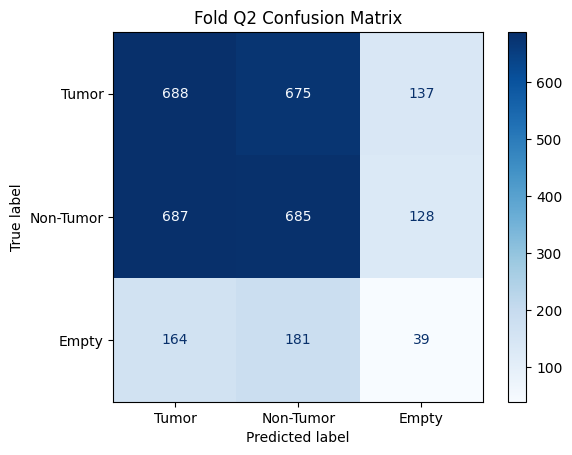

Fold Q2 Accuracy: 0.4173, F1 Score: 0.3389
Classification Report for Fold Q2:
              precision    recall  f1-score   support

       Tumor     0.4470    0.4587    0.4528      1500
   Non-Tumor     0.4445    0.4567    0.4505      1500
       Empty     0.1283    0.1016    0.1134       384

    accuracy                         0.4173      3384
   macro avg     0.3399    0.3390    0.3389      3384
weighted avg     0.4098    0.4173    0.4133      3384

Starting Fold: Test on Q3
Found 1128 validated image filenames belonging to 3 classes.
Found 3384 validated image filenames belonging to 3 classes.


/Users/homeyellow/anaconda3/envs/tfenv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 485ms/step - accuracy: 0.4563 - loss: 1.1237 - val_accuracy: 0.5700 - val_loss: 0.8622
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 481ms/step - accuracy: 0.5108 - loss: 0.9312 - val_accuracy: 0.6735 - val_loss: 0.7514
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 483ms/step - accuracy: 0.6007 - loss: 0.8216 - val_accuracy: 0.6631 - val_loss: 0.7069
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 478ms/step - accuracy: 0.6450 - loss: 0.7154 - val_accuracy: 0.7447 - val_loss: 0.6469
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 480ms/step - accuracy: 0.6675 - loss: 0.6683 - val_accuracy: 0.7444 - val_loss: 0.6209
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 477ms/step - accuracy: 0.7262 - loss: 0.6103 - val_accuracy: 0.7394 - val_loss: 0.6047
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 472ms/step - accuracy: 0.7232 - loss: 0.6072 - val_accuracy: 0.7441 - val_loss: 0.5964
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 472ms/step - accuracy: 0.7768 - loss: 0.5393 - val_accu

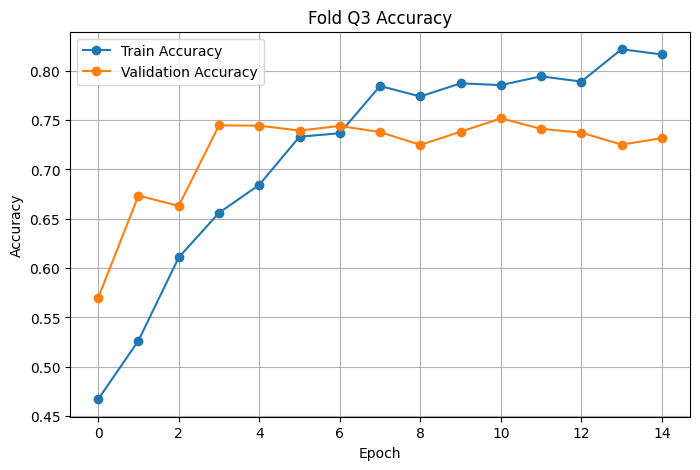

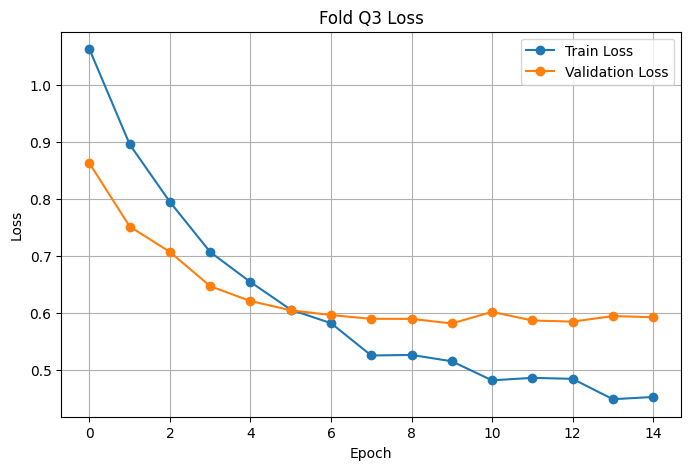

Saved model: vgg16_fold_Q3.h5
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step


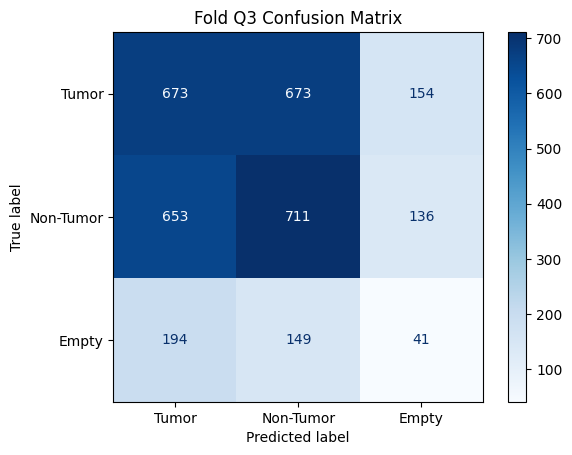

Fold Q3 Accuracy: 0.4211, F1 Score: 0.3431
Classification Report for Fold Q3:
              precision    recall  f1-score   support

       Tumor     0.4428    0.4487    0.4457      1500
   Non-Tumor     0.4638    0.4740    0.4688      1500
       Empty     0.1239    0.1068    0.1147       384

    accuracy                         0.4211      3384
   macro avg     0.3435    0.3431    0.3431      3384
weighted avg     0.4159    0.4211    0.4184      3384

Starting Fold: Test on Q4
Found 1128 validated image filenames belonging to 3 classes.
Found 3384 validated image filenames belonging to 3 classes.


/Users/homeyellow/anaconda3/envs/tfenv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 489ms/step - accuracy: 0.4591 - loss: 1.0429 - val_accuracy: 0.6079 - val_loss: 0.8446
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 481ms/step - accuracy: 0.5566 - loss: 0.9282 - val_accuracy: 0.6274 - val_loss: 0.7649
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 472ms/step - accuracy: 0.5976 - loss: 0.8429 - val_accuracy: 0.6619 - val_loss: 0.7026
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 478ms/step - accuracy: 0.6158 - loss: 0.7959 - val_accuracy: 0.6699 - val_loss: 0.6596
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 475ms/step - accuracy: 0.6517 - loss: 0.6998 - val_accuracy: 0.6546 - val_loss: 0.6476
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 475ms/step - accuracy: 0.6770 - loss: 0.7215 - val_accuracy: 0.7213 - val_loss: 0.6167
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 477ms/step - accuracy: 0.6817 - loss: 0.7012 - val_accuracy: 0.7231 - val_loss: 0.6103
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 480ms/step - accuracy: 0.6825 - loss: 0.6906 - val_accu

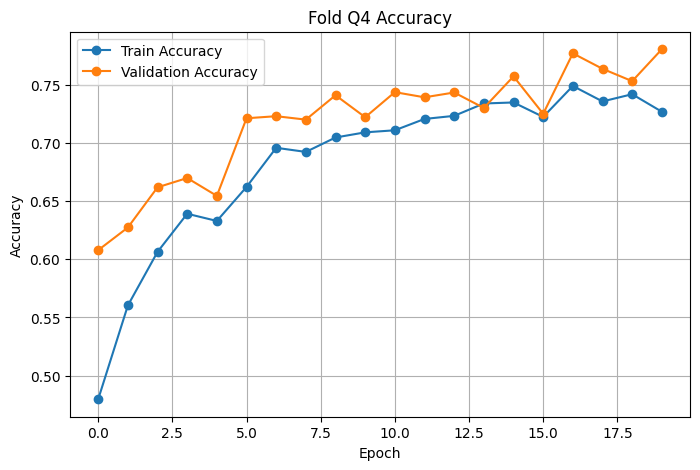

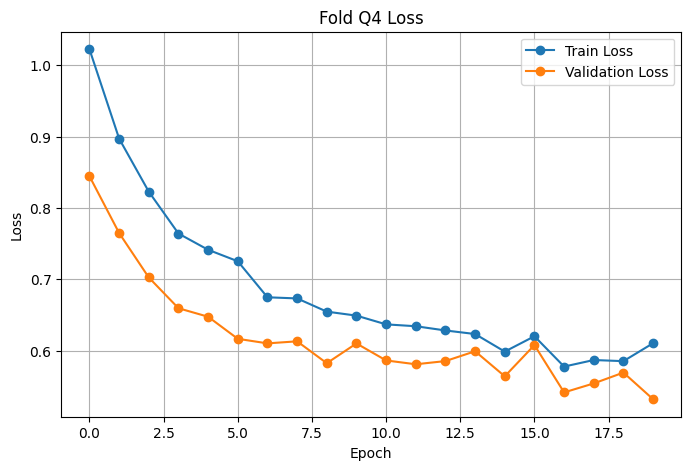

Saved model: vgg16_fold_Q4.h5
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step


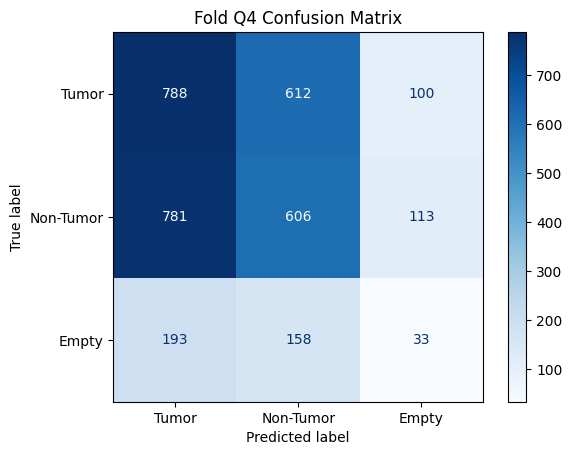

Fold Q4 Accuracy: 0.4217, F1 Score: 0.3364
Classification Report for Fold Q4:
              precision    recall  f1-score   support

       Tumor     0.4472    0.5253    0.4831      1500
   Non-Tumor     0.4404    0.4040    0.4214      1500
       Empty     0.1341    0.0859    0.1048       384

    accuracy                         0.4217      3384
   macro avg     0.3406    0.3384    0.3364      3384
weighted avg     0.4087    0.4217    0.4128      3384

Average 4-Fold Test Accuracy: 0.4180
Average 4-Fold Test Accuracy: 0.3386


In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

# Set random seeds
np.random.seed(3888)
tf.random.set_seed(3888)

# Prepare ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

quadrant_dfs = {
    "Q1": df_q1,
    "Q2": df_q2,
    "Q3": df_q3,
    "Q4": df_q4
}

# Store results
fold_accuracies = []
fold_f1_scores = []
fold_reports = []
models = {}

for quadrant in ["Q1","Q2","Q3","Q4"]:
    print(f"Starting Fold: Test on {quadrant}")

    # Split
    train_df = quadrant_dfs[quadrant]
    val_quads = [q for q in quadrant_dfs if q != quadrant]
    val_df = pd.concat([quadrant_dfs[q] for q in val_quads], ignore_index=True)

    # # Further split train/val internally
    # train_df, val_df = train_test_split(
    #     train_val_df, 
    #     test_size=0.2, 
    #     stratify=train_val_df['label'], 
    #     random_state=3888
    # )

    # Data Generators
    train_gen = train_datagen.flow_from_dataframe(
        train_df,
        x_col='Path',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    val_gen = val_test_datagen.flow_from_dataframe(
        val_df,
        x_col='Path',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    # test_gen = val_test_datagen.flow_from_dataframe(
    #     test_df,
    #     x_col='Path',
    #     y_col='label',
    #     target_size=(224, 224),
    #     batch_size=32,
    #     class_mode='binary',
    #     shuffle=False
    # )

    # Build Model
    local_path = "/hy-tmp/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
    model = build_vgg16_model(path = local_path)

    # Train
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=[early_stop],
        verbose=1
    )

    # Evaluate

    # --- Plot training curves ---
    
    # Accuracy
    plt.figure(figsize=(8,5))
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title(f'Fold {quadrant} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Loss
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title(f'Fold {quadrant} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
    
    # --- Save model ---
    model.save(f"vgg16_fold_{quadrant}.h5")
    
    models[quadrant] = model
    
    print(f"Saved model: vgg16_fold_{quadrant}.h5")
    
    # --- Confusion Matrix on Val Set ---
    val_gen.reset()
    y_true = val_gen.classes
    y_pred_probs = model.predict(val_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Tumor", "Non-Tumor", "Empty"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Fold {quadrant} Confusion Matrix')
    plt.show()

    acc = np.mean(y_true == y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Fold {quadrant} Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

    fold_accuracies.append(acc)
    fold_f1_scores.append(f1)

    # --- Classification Report ---
    report = classification_report(
    y_true, 
    y_pred, 
    target_names=["Tumor", "Non-Tumor", "Empty"],
    digits=4
    )
    fold_reports.append(report)
    print(f"Classification Report for Fold {quadrant}:\n{report}")

# Final report
mean_acc = np.mean(fold_accuracies)
mean_f1 = np.mean(fold_f1_scores)
print(f"Average 4-Fold Test Accuracy: {mean_acc:.4f}")
print(f"Average 4-Fold Test Accuracy: {mean_f1:.4f}")


In [13]:
print(f"Accuracy of Model using Q1: {fold_accuracies[0]}")
print(f"Accuracy of Model using Q2: {fold_accuracies[1]}")
print(f"Accuracy of Model using Q3: {fold_accuracies[2]}")
print(f"Accuracy of Model using Q4: {fold_accuracies[3]}")

Accuracy of Model using Q1: 0.4119385342789598
Accuracy of Model using Q2: 0.41725768321513
Accuracy of Model using Q3: 0.42109929078014185
Accuracy of Model using Q4: 0.4216903073286052


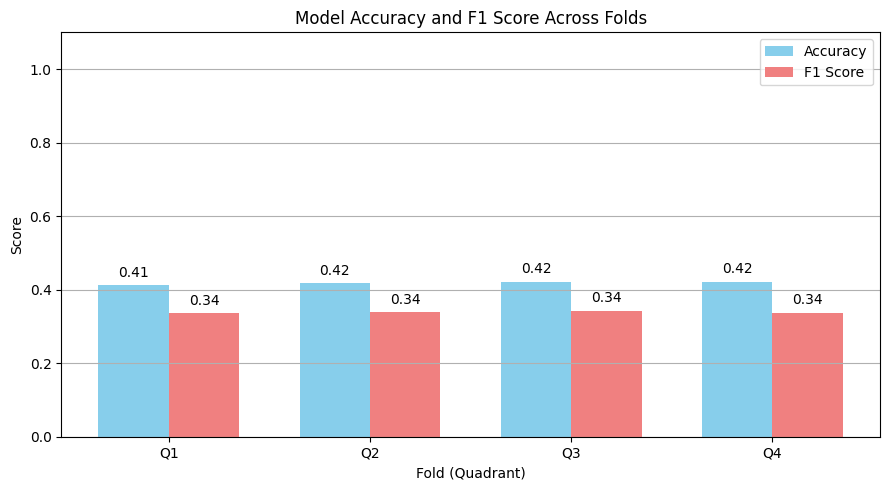

In [14]:
folds = ["Q1", "Q2", "Q3", "Q4"]

x = np.arange(len(folds))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(9, 5))

rects1 = ax.bar(x - width/2, fold_accuracies, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, fold_f1_scores, width, label='F1 Score', color='lightcoral')

# Labels and formatting
ax.set_ylabel('Score')
ax.set_xlabel('Fold (Quadrant)')
ax.set_title('Model Accuracy and F1 Score Across Folds')
ax.set_xticks(x)
ax.set_xticklabels(folds)
ax.set_ylim(0, 1.1)
ax.legend()

# Annotate each bar
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [15]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 13.4 MB/s eta 0:00:0000:0100:01


In [16]:
import cv2
import pandas as pd
from PIL import Image
import matplotlib.patches as patches
from tensorflow.keras.applications.vgg16 import preprocess_input

Image.MAX_IMAGE_PIXELS = None

# CONFIG
PATCH_SIZE = 224  # should match IMAGE_SIZE
STRIDE = 224  # adjust stride for overlapping or non-overlapping
CLASS_COLORS = {'Tumor': 0, 'Non-Tumor': 1, 'Empty': 2}
COLOR_MAP = {0: 'blue', 1: 'green', 2: 'red'}

# Load the big image
big_img = Image.open('BigImage.tif').convert('RGB')
big_arr = np.array(big_img)
h, w, _ = big_arr.shape

# model_input = preprocess_input  

# Load best-performing model
folds = ["Q1", "Q2", "Q3", "Q4"]
best_fold = folds[np.argmax(fold_f1_scores)]
best_model_path = f"vgg16_fold_{best_fold}.h5"
model = tf.keras.models.load_model(best_model_path)
print(f"Using best model from fold {best_fold}")

# ---------------- HEATMAP INFERENCE ----------------
heatmap = np.zeros((h // STRIDE, w // STRIDE), dtype=int)

for i_idx, i in enumerate(range(0, h - PATCH_SIZE + 1, STRIDE)):
    for j_idx, j in enumerate(range(0, w - PATCH_SIZE + 1, STRIDE)):
        patch = big_arr[i:i+PATCH_SIZE, j:j+PATCH_SIZE]
        patch_resized = cv2.resize(patch, IMAGE_SIZE).astype(np.float32)
        patch_input = preprocess_input(np.expand_dims(patch_resized, axis=0))  # for VGG16
        pred = model.predict(patch_input, verbose=0)
        label = np.argmax(pred)
        heatmap[i_idx, j_idx] = label

# ---------------- PLOT HEATMAP ----------------
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap, cmap='coolwarm', cbar_kws={'ticks': [0, 1, 2]},
            xticklabels=False, yticklabels=False)
plt.title(f'Prediction Heatmap using Fold {best_fold} Model')
cbar = plt.gca().collections[0].colorbar
cbar.set_ticklabels(CLASS_LABELS)
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'BigImage.tif'

In [ ]:
df = df_final
tumor_coords = []

for col in df.columns:
    if 'x' in col:
        y_col = col.replace('x', 'y')
        xs = df[col].dropna()
        ys = df[y_col].dropna()
        tumor_coords.extend(zip(xs.astype(int), ys.astype(int)))

# Build ground truth grid
gt_map = np.zeros_like(heatmap)

for x, y in tumor_coords:
    if x < w and y < h:
        i = y // STRIDE
        j = x // STRIDE
        if i < gt_map.shape[0] and j < gt_map.shape[1]:
            gt_map[i, j] = 2  # mark as tumor

# Plot heatmap with overlay
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap, cmap='coolwarm', xticklabels=False, yticklabels=False, cbar=False)
plt.title('Prediction Heatmap with Ground Truth Overlay')

# Overlay ground truth (tumor) cells
for i in range(gt_map.shape[0]):
    for j in range(gt_map.shape[1]):
        if gt_map[i, j] == 2:
            plt.gca().add_patch(patches.Rectangle((j, i), 1, 1, edgecolor='yellow', fill=False, linewidth=1))

plt.show()

KeyError: 'Image Indey'